In [1]:
# Making notebook work in Google Colab (clone repo and install requirements)
if 'google.colab' in str(get_ipython()):
    !git clone https://github.com/FELT-Labs/anomaly-detection.git
    !cp -R anomaly-detection/* .
    %pip install -r requirements.txt

In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from src.train import federated_training
from src.data import get_datafiles, get_data

# Standard Deviation

We show test calculation of standard deviation on 3 datasets and compare it with calculation on centralized data.

_Here in the notebook we run the decentralized calculation in local setting just for testing_


In [3]:
args = {
    "iterations": 1,
    "target_column": -1,
    "model_definition": {
        "model_type": "analytics",
        "model_name": "Std",
    },
}

# Split dataset into 3 files and calculate the statistics in federated setting
files = get_datafiles(3)
model = federated_training(data_files=files, **args)

print("\nDecentralized Result")
std = model.predict(None)

Training finished.
Training finished.
Training finished.
Aggregation finished.

Decentralized Result
Std value is 106.03914280262282


In [4]:
# Centralized setting, just load all data and pick target column
data = get_data().to_numpy()
y = data[:, args["target_column"]]

print("Centralized Result")
print("Std is", y.std())


Centralized Result
Std is 106.03914280262275


**We see that both results from FELT library and centralized calculation are the same.** This is important so we know that we can reliably use the FELT library and obtain same results as in centralized setting.

## Anomaly Detection (test)
We will use simple z-score to detect anomalies. This is very simple statical method, but can be efficient for detecting the biggest outliers.

$$
\text{z-score} = \frac{X - mean}{\sigma}
$$

And we will assume that any point with z-score greater than 2 is anomaly.

In [5]:
args = {
    "iterations": 1,
    "target_column": -1,
    "model_definition": [
        {
            "model_type": "analytics",
            "model_name": "Mean",
        },
        {
            "model_type": "analytics",
            "model_name": "Std",
        }
    ],
}

# Get mean, std on 3 decentralized datasets
files = get_datafiles(3)
model = federated_training(data_files=files, **args)

Training finished.
Training finished.
Training finished.
Aggregation finished.


Mean value is 47.12484333882109
Std value is 106.03914280262282
{'Mean': 47.12484333882109, 'Std': 106.03914280262282}


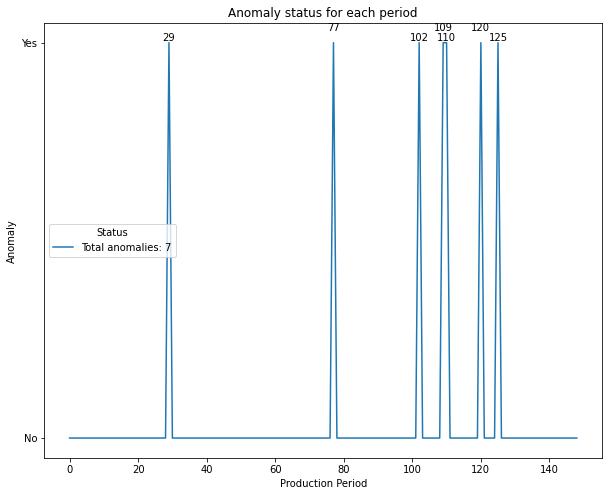

In [6]:
# Dictionary mapping model name to calculated value (e.g. {"Mean": 10, ...})
values = {m.model_name: m.predict(None) for m in model.models}
print(values)

threshold = 2
anomaly = abs((y - values["Mean"]) / values["Std"]) > threshold

plt.figure(figsize=(10, 8))
plt.plot(anomaly, label=f"Total anomalies: {sum(anomaly)}")
for i, x in enumerate(np.nonzero(anomaly)[0]):
    plt.annotate(
        f"{x}",
        (x, 1),
        textcoords="offset points",
        xytext=(0,2 + 10 * (i % 2)),
        ha='center'
    )

plt.xlabel("Production Period")
plt.ylabel("Anomaly")
plt.yticks([0, 1], ["No", "Yes"])
plt.legend(title="Status", loc=6)
plt.title("Anomaly status for each period")
# plt.savefig("result.jpg")
plt.show()